## Earth Analytics Homework - Use Time Series Data with Python
![](EarthlabSquare.png)


https://github.com/earthlab/earth-analytics-lessons/blob/master/courses/earth-analytics-python/03-intro-to-python-and-time-series-data/2018-02-05-intro-to-python-time-series-data-landing-page.ipynb

## Things that we want to check

1. order of package imports + all imports at the top
2. notebook starts at `ln 1`
3. linting -- autopep8 applied. 


For your assignment be sure to

* Load all libraries at the top of your notebook (before your code begins) in their own notebook cell.
* Follow pep-8 code style guidelines. As you do this consider
        # Comment spacing and capitalization
        Write useful comments - not too many but enough to guide a reader through your workflow
        Use line spaces and returns in your code to make it easier to read where needed
* Label all plot x and y axes - include units as necessary
* Format dates on the x axis so they are readable
* Use pandas to process your data
* Be sure to cite the source of the data used for each plot. HINT: there are metadata documents in the data folder that will help you with this.

For each plot be sure to add a markdown cell below with 2-4 sentences that plot that explains what this plot shows.

In [1]:
# Do not touch this cell. Please place the imports required from your homework in the cell below
# <Can we lock cells?>
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
import matplotcheck.raster as ra

## Grading to do
check the cell below for (in order of importance)
1. imports not used in the notebook
2. order of imports folowing PEP guidelines (most common furst to third party last)
3. spell check?

In [2]:
# Add the required packages needed to run your code here
# We normally check to see if these on in the correct order following PEP guidelines (most common first)
# BEGIN SOLUTION
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import earthpy as et
import hydrofunctions as hf
import urllib

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = (8, 8)

# prettier plotting with seaborn
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# END SOLUTION

In [3]:
# Get data
data = et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

## Homework PLOT 1 - Time series / pandas

Use pandas to open and process the `data/colorado-flood/discharge/06730200-discharge-daily-1986-2013.txt` txt file. Using this data, create a plot of monthly maximum stream discharge from 1990-2014. Document your steps used to process the data in a markdown cell BELOW the plot use pandas, make sure the dataframe has a datetime index calculate a monthly max value

Subset the data to the time period: `1990-2014` using pandas syntax `["":""]`. This means that your date column should be setup as an index.

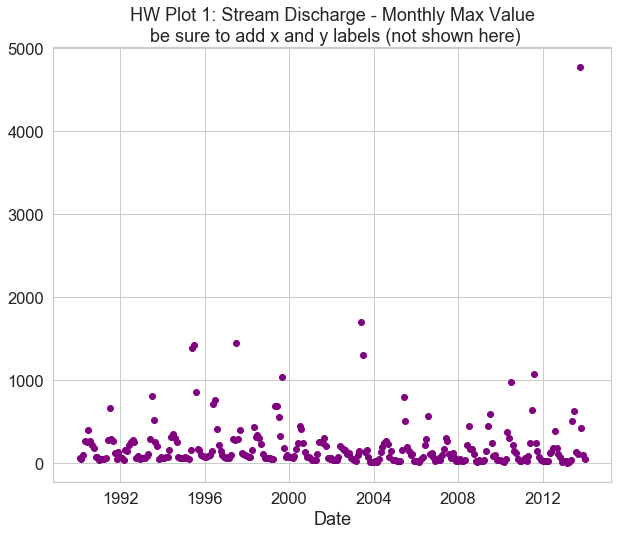

In [4]:
# BEGIN SOLUTION

# import file
f = "data/colorado-flood/discharge/06730200-discharge-daily-1986-2013.txt"
discharge = pd.read_csv(f,
                        skiprows=23,
                        header=[1, 2],
                        sep='\t',
                        parse_dates=[2])
# drop one level of index
discharge.columns = discharge.columns.droplevel(1)
# set the date column as the index
discharge = discharge.set_index(["datetime"])

monthly_max_all = discharge.resample("M").max()
monthly_max = monthly_max_all['1990':'2014']

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=monthly_max.index,
           y=monthly_max["17663_00060_00003"],
           color="purple")
ax.set_title(
    "HW Plot 1: Stream Discharge - Monthly Max Value\n be sure to add x and y labels (not shown here)")

ax.set(xlabel="Date")

# I believe we aren't supposed to use plt.show()
# plt.show()

# END SOLUTION

### DO NOT REMOVE LINE BELOW ###
ts_1_plot = nb.convert_axes(plt)

In [5]:
points = 10

# Locked Grading Cell - Homework plot 1 -
hw_plot1 = ts.TimeSeriesTester(ts_1_plot)

# Plot type and title tests (5)
if hw_plot1.assert_plot_type("scatter"):
    points += 1
if hw_plot1.assert_title_contains(["Stream discharge"]):
    points += 1


# Plot axis tests
if hw_plot1.assert_xticks_reformatted(tick_size="large", loc_exp="year", m="Please fix this"):
    points += 1

if hw_plot1.assert_axis_label_contains(axis="x", lst=["Date"]):
    points += 1

# BEGIN HIDDEN TESTS
# Add test to ensure the df has the correct values
if hw_plot1.assert_xydata(xy_expected=monthly_max.reset_index(),
                          xtime=True,
                          xcol="datetime",
                          ycol="17663_00060_00003",
                          m="oops - you messed up"):
    points += 6

# END HIDDEN TESTS
points

/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/numpy/core/numeric.py:2586: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  a1, a2 = asarray(a1), asarray(a2)


10

In [6]:
# testing wrapper function
def run_tests(plot):
    results = []
    total_points = 0

    single_result = {"test_desc": 'Are x-axis ticks reformatted?', "points": 0}
    try:
        hw_plot1.assert_xticks_reformatted(
            tick_size="large", loc_exp="year", m="Please fix this")
        single_result["points"] = 1
        single_result["message"] = "Looks good!"
    except AssertionError:
        single_result["message"] = "x ticks have not been reformatted properly"
    results.append(single_result)

    for r in results:
        total_points += float(r['points'])
        print("Testing {}. Result:  {} (points = {})".format(
            r['test_desc'], r['message'], r['points']))

    return total_points


hw_plot1 = ts.TimeSeriesTester(ts_1_plot)
run_tests(hw_plot1)

Testing Are x-axis ticks reformatted?. Result:  Looks good! (points = 1)


1.0

If all tests pass above it would be nice to be able to provide a custom message that says -- all looks good... 

# Lets try this with spatial data - new homework in same notebook

In [7]:
# Import your packages and download data / set working directory here
# BEGIN SOLUTION
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import geopandas as gpd

from shapely.geometry import mapping, box
# to create geojson object for raster cropping
from geojson import Polygon

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Get data and set working dir
data1 = et.data.get_data('cs-test-naip')
data2 = et.data.get_data('cold-springs-fire')
# set working directory to your home dir/earth-analytics
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
# END SOLUTION

In [8]:
# BEGIN SOLUTION
# Open fire boundary
fire_bound_path = "data/cold-springs-fire/vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp"
fire_bound = gpd.read_file(fire_bound_path)

# Open several spatial datasets

# Open  NAIP 2015 data & reproject fire boundary
with rio.open("data/cold-springs-fire/naip/m_3910505_nw_13_1_20150919/crop/m_3910505_nw_13_1_20150919_crop.tif") as src:
    #naip_2015_crop, naip_2015_affine = mask(src, [naip_clip_extent], crop=True)
    naip_2015_crop = src.read()
    naip_2015_bds = src.bounds
    fire_bound_utmz13 = fire_bound.to_crs(src.crs)
    naip_2015_ext = plotting_extent(naip_2015_crop[0], src.transform)
    meta = src.profile

# Create a geojson extent box to crop the other data
naip_clip_extent = mapping(box(*naip_2015_bds))

# Crop 2017 NAIP data to the 2015 data boundary
with rio.open("data/cs-test-naip/m_3910505_nw_13_1_20170902.tif") as src:
    naip_2017_crop, naip_2017_affine = es.crop_image(
        src, [box(*naip_2015_bds)])
    naip_2017_crop = naip_2017_crop.astype(int)

# END SOLUTION

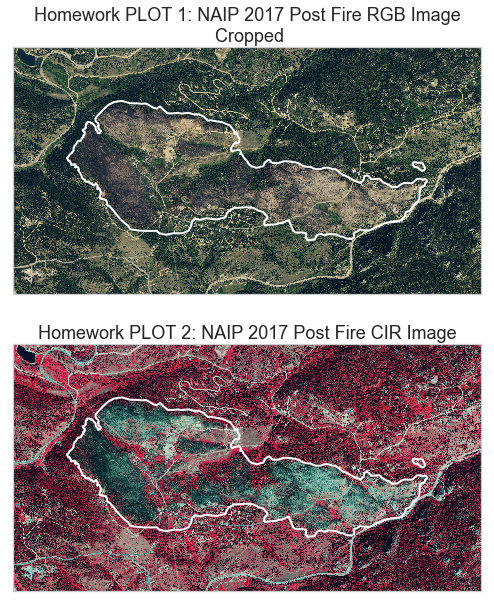

In [9]:
# Plot the data - place your final data here

# BEGIN SOLUTION

# Add plot code only for plots 1 and 2 here
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ep.plot_rgb(naip_2017_crop,
            rgb=[0, 1, 2],
            extent=naip_2015_ext,
            title="Homework PLOT 1: NAIP 2017 Post Fire RGB Image\n Cropped",
            ax=ax1)
fire_bound_utmz13.plot(ax=ax1, color='None',
                       edgecolor='white', linewidth=2)


# plot 2017 cropped data
ep.plot_rgb(naip_2017_crop,
            rgb=[3, 0, 1],
            extent=naip_2015_ext,
            title="Homework PLOT 2: NAIP 2017 Post Fire CIR Image",
            ax=ax2)
fire_bound_utmz13.plot(ax=ax2, color='None',
                       edgecolor='white', linewidth=2)

# END SOLUTION

### DO NOT REMOVE LINE BELOW ###
raster_plot = nb.convert_axes(plt, which_axes="all")

This is weird. why do my asserts work with points above but not here? here points = 0. do i have to do try excepts ?

In [ ]:
# testing wrapper function
def run_tests(plot):
    results = []
    total_points = 0

    single_result = {"test_desc": 'Are x-axis ticks reformatted?', "points": 0}
    try:
        hw_plot1.assert_xticks_reformatted(
            tick_size="large", loc_exp="year", m="Please fix this")
        single_result["points"] = 1
        single_result["message"] = "Looks good!"
    except AssertionError:
        single_result["message"] = "x ticks have not been reformatted properly"
    results.append(single_result)

    for r in results:
        total_points += float(r['points'])
        print("Testing {}. Result:  {} (points = {})".format(
            r['test_desc'], r['message'], r['points']))

    return total_points

# not sure how to do this. also i remember yuvi having a way to do this that was language agnostic.
def run_test(test, total_points, correct_message, error_message):
    # test each input
    
    results = []
    single_result = {"test_desc": 'Are x-axis ticks reformatted?', "points": 0}
    try:
        test
        single_result["points"] = total_points
        single_result["message"] = correct_message
    except AssertionError:
        single_result["message"] = error_message
        
    return single_result
    
    
    

In [30]:
# raster tests

points = 0
results = []
# in this case our plot has several axes which we need to test individually.
# so the use case here will require loops which a function will be good for. writing it all out first.
hw_raster_plot1 = ra.RasterTester(raster_plot[0])

# Run tests
try:
    hw_raster_plot1.assert_axis_off()
    points += 1
    results["message"] = "Axis format looks great! Points=1."
except AssertionError:
    results["message"] = "Looks like your axis is still on. Please turn axis_off."

# HIDDEN TESTS
# Calculate expected rasters  - plot one RGB image

rgb = [0, 1, 2]
rgb_bands = naip_2017_crop[rgb, :, :]
im = es.bytescale(rgb_bands).transpose([1, 2, 0])

if hw_raster_plot1.assert_image(im):
    points += 5

# CIR image - plot 2
hw_raster_plot2 = ra.RasterTester(raster_plot[1])

rgb2 = [3, 0, 1]
rgb_bands2 = naip_2017_crop[rgb2, :, :]
im2 = es.bytescale(rgb_bands2).transpose([1, 2, 0])

if hw_raster_plot2.assert_image(im2):
    points += 5

points, results

for r in results:
    total_points += float(r['points'])
    print("Testing {}. Result:  {} (points = {})".format(
        r['test_desc'], r['message'], r['points']))

TypeError: list indices must be integers or slices, not str

In [ ]:
# Test dataframe format
# Here i want the student to provide a data frame. but we may not know what it is called.
# then i want to test the structure - that it has an index of type "timestame"
test = monthly_max.reset_index().index


assert type(test[0]) == pd._libs.tslibs.timestamps.Timestamp